In [ ]:
## read input dictionary to be used as labeling functions
import os
import csv
import ast

def read_label_dict(file_name):
    with open(file_name, 'r') as f:  
        rows = csv.reader(f)
        label_dict = {}
        for r in rows:
            values = label_dict.get(r[0], [])
            values.append(r[1])
            label_dict[r[0]] = values
        return label_dict
        
gt_file = "../inputs/mlopen-text-tables.gt" 
label_dir = "../column-labels"
data_lake = "mlopen" 
wem_label_dict = read_label_dict(os.path.join(label_dir, data_lake + "-wem.lbl"))
lshe_label_dict = read_label_dict(os.path.join(label_dir, data_lake + "-lshe.lbl"))
content_label_dict = read_label_dict(os.path.join(label_dir, data_lake + "-content.lbl"))
colname_label_dict = read_label_dict(os.path.join(label_dir, data_lake + "-colname.lbl"))
tblname_label_dict = read_label_dict(os.path.join(label_dir, data_lake + "-tblname.lbl"))



In [ ]:
## labelling functions
from snorkel.labeling import labeling_function
from snorkel.labeling import LFAnalysis
from snorkel.labeling import PandasLFApplier

@labeling_function()
def lf_wem_index(x):
    x_c = x.context_index
    x_t = x.table_id
    hits = wem_label_dict.get(x_c, [])
    if x_t in hits:
        return 1
    else:
        return -1

@labeling_function()
def lf_lshe_index(x):
    x_c = x.context_index
    x_t = x.table_id
    hits = lshe_label_dict.get(x_c, [])
    if x_t in hits:
        return 1
    else:
        return -1

@labeling_function()
def lf_content_index(x):
    x_c = x.context_index
    x_t = x.table_id
    hits = content_label_dict.get(x_c, [])
    if x_t in hits:
        return 1
    else:
        return -1

@labeling_function()
def lf_colname_index(x):
    x_c = x.context_index
    x_t = x.table_id
    hits = colname_label_dict.get(x_c, [])
    if x_t in hits:
        return 1
    else:
        return -1

@labeling_function()
def lf_tblname_index(x):
    x_c = x.context_index
    x_t = x.table_id
    hits = tblname_label_dict.get(x_c, [])
    if x_t in hits:
        return 1
    else:
        return -1



In [ ]:
import pandas as pd
from tqdm import tqdm

def merge_unique(lists, previous=[]):
    data = set(previous)
    #print(f'{len(lists)} lists received, first: {type(lists[0])}')
    for l in lists:
        data.update(l)
    return list(data)

x_contexttext = merge_unique([wem_label_dict.keys(), lshe_label_dict.keys(), content_label_dict.keys(), colname_label_dict.keys(), tblname_label_dict.keys()])

print(f'Text len: {len(x_contexttext)}, sample: {x_contexttext[:5]}')
join_data = []
for x_c in tqdm(x_contexttext):
    for x_t in merge_unique([wem_label_dict.get(x_c, []), lshe_label_dict.get(x_c, []), content_label_dict.get(x_c, []), colname_label_dict.get(x_c, []), tblname_label_dict.get(x_c, [])]):
        #print(f'Joining {x_c} to {x_t}')
        join_data.append([x_c, x_t])
df_train = pd.DataFrame(join_data, columns=['context_index', 'table_id'])
print(f'training data: {df_train}')
        


In [ ]:
## read gold labels
import numpy as np

def gt_map(gt_file, sep=','):
  gt = {}
  with open(gt_file, 'r') as f:
    csvf = csv.reader(f, delimiter=sep)
    for line in tqdm(csvf):
      key = line[0].strip('\'')
      value = line[1].strip('\'')
      gt.setdefault(key, []).append(value)
  return gt

gt = gt_map(gt_file)
print(f'GT size: {len(gt)}')
Y_test = []
for index, row in tqdm(df_train.iterrows()):
        gt_vals = gt.get(row['context_index'], [])
        tblname = row['table_id'].split(',')[0]
        if tblname in gt_vals:
            Y_test.append(1)
            continue
        Y_test.append(0)
        
Y_test = np.array(Y_test)
print(f'Populated Y_test {len(Y_test)}, number of 1s = {(Y_test==1).sum()}')

In [21]:
from snorkel.labeling.model import LabelModel

lfs = [lf_wem_index, lf_lshe_index, lf_content_index, lf_colname_index, lf_tblname_index]
#lfs = [lf_wem_index, lf_lshe_index, lf_content_index]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
print(f'L_train matrix: {L_train.shape}')
LFAnalysis(L=L_train, lfs=lfs).lf_summary(Y_test)



100%|██████████| 50068/50068 [00:04<00:00, 11166.09it/s]


L_train matrix: (50068, 5)


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_wem_index,0,[1],0.440681,0.226312,0.0,8875,13189,0.402239
lf_lshe_index,1,[1],0.410362,0.139810,0.0,3990,16556,0.194198
lf_content_index,2,[1],0.275425,0.180515,0.0,6645,7145,0.481871
lf_colname_index,3,[1],0.175841,0.037269,0.0,1350,7454,0.153339
lf_tblname_index,4,[1],0.024766,0.008029,0.0,190,1050,0.153226


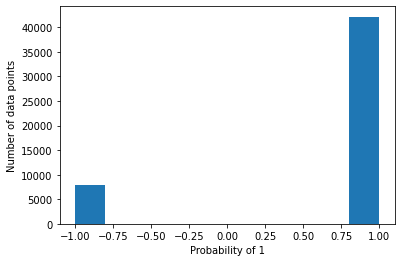

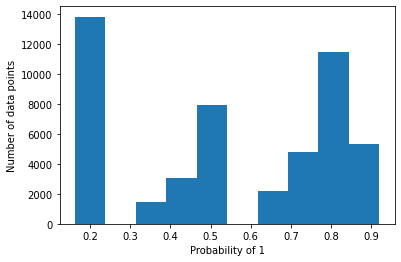

Label Model Accuracy:     58.8%


In [19]:
from snorkel.labeling.model import LabelModel
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling import filter_unlabeled_dataframe
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def plot_label_frequency(L):
    plt.hist((L != -1).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()

def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of 1")
    plt.ylabel("Number of data points")
    plt.show()

#plot_label_frequency(L_train)

## test on training set
df_test = df_train

def gt_tuples(gt_file, sep=','):
  gt_tuples = []
  with open(gt_file, 'r') as f:
    csvf = csv.reader(f, delimiter=sep)
    for line in tqdm(csvf):
      key = line[0].strip('\'')
      value = line[1].strip('\'')
      gt_tuples.append((key, value))
  return gt_tuples


# label model
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)
probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, 1])

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
  "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")



In [ ]:
## write labels to file
snorkel_out_file = '../column-labels/' + data_lake + '-snorkel.lbl'

def write_csv(fp, tuples):
    with open(fp, 'w') as f:
        csvf = csv.writer(f)
        for t in tuples:
            csvf.writerow(t)
            
out_tuples = []
for i, r in df_train.iterrows():
    key = r['context_index']
    target = r['table_id']
    score = probs_train[i, 1] # probability of label 1
    out_tuples.append((key, target, score))

write_csv(snorkel_out_file, out_tuples)